In [206]:
#load library
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
from fractions import Fraction
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.misc import toimage
from numba import jit
import timeit
from numba import vectorize, int64, float64,guvectorize

In [207]:
np.random.seed(12)

In [208]:
#this function is the main solver for the indian buffet
#input: N is the number of the objects, and alpha is any integer
#output: Z is the binary matrix, K is the number of features (prior)
def IBP( N,alpha ):
    #Generate initial number of features from a Poisson
    n_init = np.random.poisson(alpha,1)
    Z = np.zeros(shape=(N,n_init))
    Z[0,:] = 1
    m = np.sum(Z,0)
    K = n_init
    for i in range(1,N):
        #Calculate probability of visiting past dishes
        prob = m/(i+1)
        index = np.greater(prob,np.random.rand(1,K))
        Z[i,:] = index.astype(int);
        #Calculate the number of new dishes visited by customer i
        knew = np.random.poisson(alpha/(i+1),1)
        Z=np.concatenate((Z,np.zeros(shape=(N,knew))), axis=1)
        Z[i,K:K+knew:1] = 1
        #Update matrix size and number of features 
        K = K+knew
        m = sum(Z,0)
    return Z, K

In [209]:
#initialize varible values
dimension = 36
objects = 100
feature = 4
paperImagesetting=6
iteration = 200

In [210]:
#basis setting as paper
b_1 = np.array([[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,1,0,0,0,0],[1,1,1,0,0,0],[0,1,0,0,0,0]])
b_2 = np.array([[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,1,1,1],[0,0,0,1,0,1],[0,0,0,1,1,1]])
b_3 = np.array([[1,1,1,0,0,0],[1,1,0,0,0,0],[1,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])
b_4 = np.array([[0,0,0,0,1,0],[0,0,0,0,1,0],[0,0,0,1,1,1],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])
basis_4=np.array([b_1,b_2,b_3,b_4])

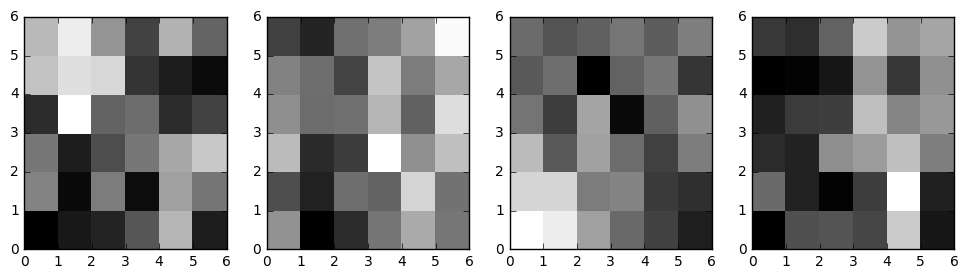

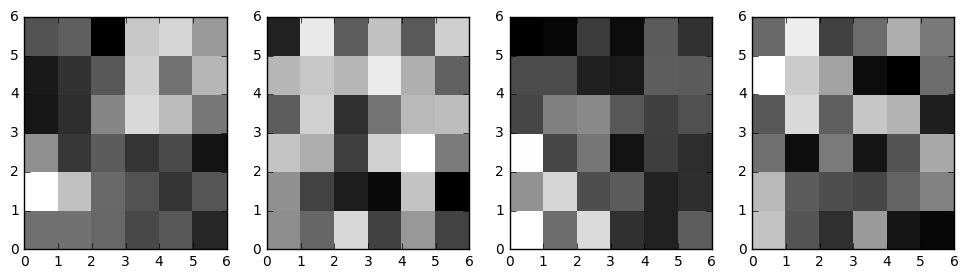

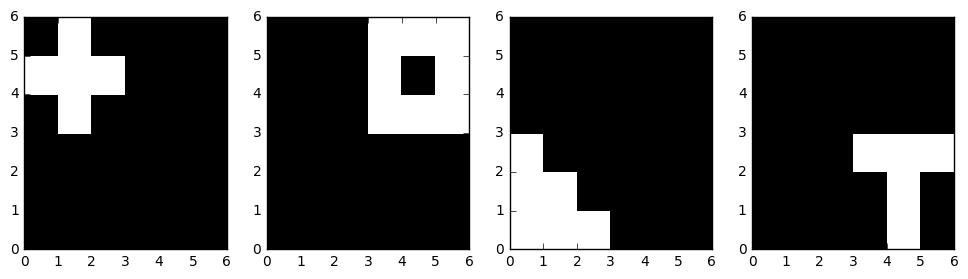

In [211]:
#plot the basis
fig = plt.figure(figsize=(12,3))
fig1 = fig.add_subplot(141)
fig1.pcolormesh(b_1,cmap=plt.cm.gray)     
fig2 = fig.add_subplot(142)
fig2.pcolormesh(b_2,cmap=plt.cm.gray)  
fig3 = fig.add_subplot(143)
fig3.pcolormesh(b_3,cmap=plt.cm.gray)  
fig4 = fig.add_subplot(144)
fig4.pcolormesh(b_4,cmap=plt.cm.gray) 
plt.show()
fig.savefig('original_plots_regular_profile.png')

In [212]:
A = np.array([b_1.reshape(dimension),b_2.reshape(dimension),b_3.reshape(dimension),b_4.reshape(dimension)])

In [213]:
#Simulate figure
SimulatedImage = np.zeros((objects,paperImagesetting,paperImagesetting)) 
coef = stats.bernoulli.rvs(0.5,size=(objects,feature))
noise = stats.norm.rvs(loc=0,scale=0.5,size = (objects,paperImagesetting,paperImagesetting)) 

In [214]:
#this function is used to generate simulate figure based on the basis and linear model
def simulated_image(objects,basis_4,coef,noise,paperImagesetting,feature):
    SimulatedImage = np.zeros((objects,paperImagesetting,paperImagesetting))
    for i in range(objects):
        for j in range(feature):
            SimulatedImage[i,:,:]+=coef[i,j]*basis_4[j,:,:]
        SimulatedImage[i,:,:]+= noise[i,:,:]
    return SimulatedImage

In [215]:
#plot simulate plots
SimulatedImage=simulated_image(objects,basis_4,coef,noise,paperImagesetting,feature)
fig=plt.figure(figsize=(12,3))
fig1 = fig.add_subplot(141)
fig1.pcolormesh(SimulatedImage[2],cmap=plt.cm.gray)
fig1 = fig.add_subplot(142)
fig1.pcolormesh(SimulatedImage[10],cmap=plt.cm.gray)
fig1 = fig.add_subplot(143)
fig1.pcolormesh(SimulatedImage[30],cmap=plt.cm.gray)
fig1 = fig.add_subplot(144)
fig1.pcolormesh(SimulatedImage[80],cmap=plt.cm.gray)
fig.savefig('simulation_regular_profile.png')

In [216]:
sA = 1.2
sX = 1.7
alpha=1

In [217]:
#generate binary matrix and features based on the indian buffet process
Z,K=IBP(objects,alpha)

In [218]:
Z_mcmc= np.zeros((iteration,objects,2000))
K_mcmc = np.zeros(iteration)
sX_mcmc = np.zeros(iteration)
sA_mcmc = np.zeros(iteration)
alpha_mcmc = np.zeros(iteration)
ratioX = 0
ratioA = 0
X = np.zeros((objects,dimension))
Z0= np.zeros((objects,feature))

In [219]:
HN = 0
for i in range(objects):
    HN+=1/(i+1)

In [220]:
sX0=0.5

In [221]:
def samplex(objects,sX0,dimension,Z0,feature):
    X = np.zeros((objects,dimension))
    for i in range(objects):
        while True:
            pp=np.round(stats.uniform.rvs(loc=0,scale=1,size=feature)).astype(int)
            if np.sum(pp)!=0:
                Z0[i,:] =pp
                break
        X[i,:] =  np.dot(Z0[i,:],A)+np.random.normal(size=dimension)*sX0
    return X

In [222]:
X=samplex(objects,sX0,dimension,Z0,feature)

In [223]:
fig=plt.figure(figsize=(12,3))
fig1 = fig.add_subplot(141)
fig1.pcolormesh(X[2].reshape(6,6),cmap=plt.cm.gray)
fig1 = fig.add_subplot(142)
fig1.pcolormesh(X[10].reshape(6,6),cmap=plt.cm.gray)
fig1 = fig.add_subplot(143)
fig1.pcolormesh(X[20].reshape(6,6),cmap=plt.cm.gray)
fig1 = fig.add_subplot(144)
fig1.pcolormesh(X[50].reshape(6,6),cmap=plt.cm.gray)
fig.savefig('Ximages_regular_profile.png')

In [224]:
def calcM(Z,Kplus,sigmaX,sigmaA):
    return np.linalg.inv(np.dot(Z[:,0:Kplus].T,Z[:,0:Kplus])+((sigmaX/sigmaA)**2)*np.identity(Kplus))
def calcM2(Z,Kplus,kterm,sigmaX,sigmaA):
    return np.linalg.inv(np.dot(Z[:,0:Kplus+kterm].T,Z[:,0:Kplus+kterm])+((sigmaX/sigmaA)**2)*np.identity(Kplus+kterm))
def log_likelihood(X,Z,M,sigmaA,sigmaX,Kplus,N,D):  
    determinant = np.linalg.det(np.dot(Z.T,Z)+((sigmaX/sigmaA)**2)*np.identity(Kplus))
    constant = N*D*0.5*np.log(2*np.pi) + (N-Kplus)*D*np.log(sigmaX) + Kplus*D*np.log(sigmaA) + D*0.5*np.log(determinant)
    middle = np.identity(N) - np.dot(np.dot(Z, M),Z.T)
    trace = np.trace(np.dot(np.dot(X.T,middle),X))
    kernel = -0.5*np.reciprocal(sigmaX**2)*trace
    log_lik = -constant + kernel
    return log_lik

In [225]:
@jit
def calcM_jit(Z,Kplus,sigmaX,sigmaA):
    return np.linalg.inv(np.dot(Z[:,0:Kplus].T,Z[:,0:Kplus])+((sigmaX/sigmaA)**2)*np.identity(Kplus))

In [226]:
@jit
def calcM2_jit(Z,Kplus,kterm,sigmaX,sigmaA):
    return np.linalg.inv(np.dot(Z[:,0:Kplus+kterm].T,Z[:,0:Kplus+kterm])+((sigmaX/sigmaA)**2)*np.identity(Kplus+kterm))

In [227]:
@jit
def log_likelihood_jit(X,Z,M,sigmaA,sigmaX,Kplus,N,D):  
    determinant = np.linalg.det(np.dot(Z.T,Z)+((sigmaX/sigmaA)**2)*np.identity(Kplus))
    constant = N*D*0.5*np.log(2*np.pi) + (N-Kplus)*D*np.log(sigmaX) + Kplus*D*np.log(sigmaA) + D*0.5*np.log(determinant)
    
    middle = np.identity(N) - np.dot(np.dot(Z, M),Z.T)
    trace = np.trace(np.dot(np.dot(X.T,middle),X))
    kernel = -0.5*np.reciprocal(sigmaX**2)*trace
    
    log_lik = -constant + kernel
    return log_lik

In [228]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [229]:
%%cython -a
import cython
import numpy as np
cimport numpy as np
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

def calcM_cython(double[:,:] Z,int Kplus,double sigmaX,double sigmaA): 
    cdef double [:,:] temp =np.dot(Z[:,0:Kplus].T,Z[:,0:Kplus])
    cdef float temp2=(sigmaX/sigmaA)**2
    cdef double [:,:] iden=(temp2)*np.identity(Kplus)

    cdef double [:,:] resu = iden
    for i in range(Kplus):
        for j in range(Kplus):
            resu[i,j]=iden[i,j]+temp[i,j]
    
    return np.linalg.inv(resu)

In [230]:
%%cython -a
import cython
import numpy as np
cimport numpy as np
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

def calcM2_cython(double[:,:] Z,int Kplus,int kterm,double sigmaX,double sigmaA): 
    cdef double [:,:] temp =np.dot(Z[:,0:Kplus+kterm].T,Z[:,0:Kplus+kterm])
    cdef float temp2=(sigmaX/sigmaA)**2
    cdef double [:,:] iden=(temp2)*np.identity(Kplus+kterm)

    cdef double [:,:] resu = iden
    for i in range(Kplus+kterm):
        for j in range(Kplus+kterm):
            resu[i,j]=iden[i,j]+temp[i,j]
    
    return np.linalg.inv(resu)

In [231]:
%%cython -a
import cython
import numpy as np
cimport numpy as np
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

def log_likelihood_cython(double[:,:] X,double[:,:] Z, double[:,:] M,double sigmaA,double sigmaX,int Kplus,int N,int D):  
    cdef double determinant = np.linalg.det(np.dot(Z.T,Z)+((sigmaX/sigmaA)**2)*np.identity(Kplus))
    cdef double constant = N*D*0.5*np.log(2*np.pi) + (N-Kplus)*D*np.log(sigmaX) + Kplus*D*np.log(sigmaA) + D*0.5*np.log(determinant)
    
    cdef double[:,:] middle = np.identity(N) - np.dot(np.dot(Z, M),Z.T)
    cdef double trace = np.trace(np.dot(np.dot(X.T,middle),X))
    cdef double kernel = -0.5*np.reciprocal(sigmaX**2)*trace
    
    cdef double result = -constant + kernel
    return  result

In [232]:
def mainsolver_improve(iteration,Z,alpha,K,sX,sA,ratioX = 0,ratioA = 0): 
    Z_mcmc= np.zeros((iteration,objects,1000))
    K_mcmc = np.zeros(iteration)
    sX_mcmc = np.zeros(iteration)
    sA_mcmc = np.zeros(iteration)
    alpha_mcmc = np.zeros(iteration)
    for it in range(iteration):
        Z_mcmc[it,:,0:K] = Z[:,0:K]
        alpha_mcmc[it] = alpha
        K_mcmc[it] = K
        sX_mcmc[it] = sX
        sA_mcmc[it] = sA
        for i in range(objects):
            for k in range(K):
                if k+1>K:
                    break
                if Z[i,k]>0:
                    if np.sum(Z[:,k])-Z[i,k]<=0:
                        Z[:,k:(K-1)] = Z[:,(k+1):K]
                        K -= 1
                        continue
                P = np.zeros(2)
                Z[i,k] = 1
                M1 = calcM_jit(Z,K,sX,sA) 
                P[1] = log_likelihood_jit(X,Z[:,0:K],M1,sA,sX,K,objects,dimension) + np.log(sum(Z[:,k])-Z[i,k]) - np.log(objects)
                Z[i,k] = 0
                M0 = calcM_jit(Z,K,sX,sA) 
                P[0] = log_likelihood_jit(X,Z[:,0:K],M0,sA,sX,K,objects,dimension) + np.log(objects-sum(Z[:,k])) - np.log(objects)
                P = np.exp(P - max(P))
                p = stats.uniform.rvs(loc=0,scale=1,size=1)           
                if p < P[0]/(P[0]+P[1]):
                    Z[i,k] = 0
                else:
                    Z[i,k] = 1
            
            trun=np.zeros(feature)
            alphan=alpha/objects
            for k_i in range(4):
                if k_i > 0:
                    temp = np.zeros((objects,k_i))
                    temp[i,:] = 1
                    Z = np.hstack((Z[:,0:K],temp))
                M = calcM2_jit(Z,K,k_i,sX,sA)
                trun[k_i] = (k_i)*np.log(alphan) - alphan - np.log(np.math.factorial(k_i)) +log_likelihood_jit(X,Z[:,0:(K+k_i)],M,sA,sX,K+k_i,objects,dimension)
            Z[i,K:(K+3)] = 0
            trun = np.exp(trun-max(trun))
            trun = trun/np.sum(trun) 
            t = 0
            for ki in range(4):
                t += trun[ki]
                if p < t:
                    ff1 = ki
                    break
            Z[i,K:(K+ff1)] = 1
            K += ff1
        M=calcM_jit(Z,K,sX,sA)
        l1=log_likelihood_jit(X, Z[:,0:K], M, sA, sX, K, objects, dimension)
        if p<0.5:
            pppsX = sX - p/20
        else:
            pppsX = sX + p/20
        M_X = calcM_jit(Z, K, pppsX, sA)
        l2=log_likelihood_jit(X, Z[:,0:K], M_X, sA, pppsX, K, objects, dimension)
        acc_X = np.exp(min(0, l2-l1))
        if p<0.5:
            pppsA = sA - p/20
        else:
            pppsA = sA + p/20
        M_A = calcM_jit(Z, K, sX, pppsA)
        l3=log_likelihood_jit(X, Z[:,0:K], M_A, pppsA, sX, K, objects, dimension)
        acc_A = np.exp(min(0, l3-l1)) 
        if p < acc_X:
            sX = pppsX
            ratioX += 1
        if p < acc_A:
            sA = pppsA
            ratioA += 1
        alpha = stats.gamma.rvs(a = 1+K, loc = 0, scale = np.reciprocal(1+HN),size=1)[0]   
    return Z_mcmc, K_mcmc,sX_mcmc,sA_mcmc,alpha_mcmc

In [233]:
def mainsolver_improve_cython(iteration,Z,alpha,K,sX,sA,ratioX = 0,ratioA = 0): 
    Z_mcmc= np.zeros((iteration,objects,1000))
    K_mcmc = np.zeros(iteration)
    sX_mcmc = np.zeros(iteration)
    sA_mcmc = np.zeros(iteration)
    alpha_mcmc = np.zeros(iteration)
    for it in range(iteration):
        Z_mcmc[it,:,0:K] = Z[:,0:K]
        alpha_mcmc[it] = alpha
        K_mcmc[it] = K
        sX_mcmc[it] = sX
        sA_mcmc[it] = sA
        for i in range(objects):
            for k in range(K):
                if k+1>K:
                    break
                if Z[i,k]>0:
                    if np.sum(Z[:,k])-Z[i,k]<=0:
                        Z[:,k:(K-1)] = Z[:,(k+1):K]
                        K -= 1
                        continue
                P = np.zeros(2)
                Z[i,k] = 1
                M1 = calcM_cython(Z,K,sX,sA) 
                P[1] = log_likelihood_cython(X,Z[:,0:K],M1,sA,sX,K,objects,dimension) + np.log(sum(Z[:,k])-Z[i,k]) - np.log(objects)
                Z[i,k] = 0
                M0 = calcM_cython(Z,K,sX,sA) 
                P[0] = log_likelihood_cython(X,Z[:,0:K],M0,sA,sX,K,objects,dimension) + np.log(objects-sum(Z[:,k])) - np.log(objects)
                P = np.exp(P - max(P))
                p = stats.uniform.rvs(loc=0,scale=1,size=1)           
                if p < P[0]/(P[0]+P[1]):
                    Z[i,k] = 0
                else:
                    Z[i,k] = 1
            trun=np.zeros(feature)
            alphan=alpha/objects
            for k_i in range(4):
                if k_i > 0:
                    temp = np.zeros((objects,k_i))
                    temp[i,:] = 1
                    Z = np.hstack((Z[:,0:K],temp))
                M = calcM2_cython(Z,K,k_i,sX,sA)
                trun[k_i] = (k_i)*np.log(alphan) - alphan - np.log(np.math.factorial(k_i)) +log_likelihood_cython(X,Z[:,0:(K+k_i)],M,sA,sX,K+k_i,objects,dimension)
            Z[i,K:(K+3)] = 0
            trun = np.exp(trun-max(trun))
            trun = trun/np.sum(trun) 
            t = 0
            for ki in range(4):
                t += trun[ki]
                if p < t:
                    ff1 = ki
                    break
            Z[i,K:(K+ff1)] = 1
            K += ff1
        M=calcM_cython(Z,K,sX,sA)
        l1=log_likelihood_cython(X, Z[:,0:K], M, sA, sX, K, objects, dimension)
        if p<0.5:
            pppsX = sX - p/20
        else:
            pppsX = sX + p/20
        M_X = calcM_cython(Z, K, pppsX, sA)
        l2=log_likelihood_cython(X, Z[:,0:K], M_X, sA, pppsX, K, objects, dimension)
        acc_X = np.exp(min(0, l2-l1))
        if p<0.5:
            pppsA = sA - p/20
        else:
            pppsA = sA + p/20
        M_A = calcM_cython(Z, K, sX, pppsA)
        l3=log_likelihood_cython(X, Z[:,0:K], M_A, pppsA, sX, K, objects, dimension)
        acc_A = np.exp(min(0, l3-l1)) 
        if p < acc_X:
            sX = pppsX
            ratioX += 1
        if p < acc_A:
            sA = pppsA
            ratioA += 1
        alpha = stats.gamma.rvs(a = 1+K, loc = 0, scale = np.reciprocal(1+HN),size=1)[0]   
    return Z_mcmc, K_mcmc,sX_mcmc,sA_mcmc,alpha_mcmc

In [234]:

def mainsolver(iteration,Z,alpha,K,sX,sA,ratioX = 0,ratioA = 0): 
    Z_mcmc= np.zeros((iteration,objects,1000))
    K_mcmc = np.zeros(iteration)
    sX_mcmc = np.zeros(iteration)
    sA_mcmc = np.zeros(iteration)
    alpha_mcmc = np.zeros(iteration)
    for it in range(iteration):
        print(it)
        Z_mcmc[it,:,0:K] = Z[:,0:K]
        alpha_mcmc[it] = alpha
        K_mcmc[it] = K
        sX_mcmc[it] = sX
        sA_mcmc[it] = sA
        for i in range(objects):
            for k in range(K):
                if k+1>K:
                    break
                if Z[i,k]>0:
                    if np.sum(Z[:,k])-Z[i,k]<=0:
                        Z[:,k:(K-1)] = Z[:,(k+1):K]
                        K -= 1
                        continue
                P = np.zeros(2)
                Z[i,k] = 1
                M1 = calcM(Z,K,sX,sA) 
                P[1] = log_likelihood(X,Z[:,0:K],M1,sA,sX,K,objects,dimension) + np.log(sum(Z[:,k])-Z[i,k]) - np.log(objects)
                Z[i,k] = 0
                M0 = calcM(Z,K,sX,sA) 
                P[0] = log_likelihood(X,Z[:,0:K],M0,sA,sX,K,objects,dimension) + np.log(objects-sum(Z[:,k])) - np.log(objects)
                P = np.exp(P - max(P))
                p = stats.uniform.rvs(loc=0,scale=1,size=1)           
                if p < P[0]/(P[0]+P[1]):
                    Z[i,k] = 0
                else:
                    Z[i,k] = 1
            
            trun=np.zeros(feature)
            alphan=alpha/objects
            for k_i in range(4):
                if k_i > 0:
                    temp = np.zeros((objects,k_i))
                    temp[i,:] = 1
                    Z = np.hstack((Z[:,0:K],temp))
                M = calcM2(Z,K,k_i,sX,sA)
                trun[k_i] = (k_i)*np.log(alphan) - alphan - np.log(np.math.factorial(k_i)) +log_likelihood(X,Z[:,0:(K+k_i)],M,sA,sX,K+k_i,objects,dimension)
            Z[i,K:(K+3)] = 0
            trun = np.exp(trun-max(trun))
            trun = trun/np.sum(trun) 
            t = 0
            for ki in range(4):
                t += trun[ki]
                if p < t:
                    ff1 = ki
                    break
            Z[i,K:(K+ff1)] = 1
            K += ff1
        M=calcM(Z,K,sX,sA)
        l1=log_likelihood(X, Z[:,0:K], M, sA, sX, K, objects, dimension)
        if p<0.5:
            pppsX = sX - p/20
        else:
            pppsX = sX + p/20
        M_X = calcM(Z, K, pppsX, sA)
        l2=log_likelihood(X, Z[:,0:K], M_X, sA, pppsX, K, objects, dimension)
        acc_X = np.exp(min(0, l2-l1))
        if p<0.5:
            pppsA = sA - p/20
        else:
            pppsA = sA + p/20
        M_A = calcM(Z, K, sX, pppsA)
        l3=log_likelihood(X, Z[:,0:K], M_A, pppsA, sX, K, objects, dimension)
        acc_A = np.exp(min(0, l3-l1)) 
        if p < acc_X:
            sX = pppsX
            ratioX += 1
        if p < acc_A:
            sA = pppsA
            ratioA += 1
        alpha = stats.gamma.rvs(a = 1+K, loc = 0, scale = np.reciprocal(1+HN),size=1)[0]   
    return Z_mcmc, K_mcmc,sX_mcmc,sA_mcmc,alpha_mcmc

In [ ]:
def work(iteration,Z,alpha,K,sX,sA,ratioX = 0,ratioA = 0):
    mainsolver(iteration,Z,alpha,K,sX,sA)
    mainsolver_improve_cython(iteration,Z,alpha,K,sX,sA)
    mainsolver_improve(iteration,Z,alpha,K,sX,sA)
    
    

In [ ]:
%prun -q -D work.prof work(iteration,Z,alpha,K,sX,sA)

In [ ]:
import pstats
p=pstats.Stats('work.prof')
p.print_stats()
pass

In [ ]:
p.sort_stats('time','cumulative').print_stats('main')

In [235]:
%timeit -n1 -r1 Z_mcmc, K_mcmc,sX_mcmc,sA_mcmc,alpha_mcmc=mainsolver_improve_cython(iteration,Z,alpha,K,sX,sA)

1 loop, best of 1: 49.5 s per loop


In [ ]:
%load_ext line_profiler

In [ ]:
%lprun -s -f mainsolver mainsolver(iteration,Z,alpha,K,sX,sA)

In [ ]:
%lprun -s -f mainsolver_improve_cython mainsolver_improve_cython(iteration,Z,alpha,K,sX,sA)